In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
from tqdm import tqdm_notebook as tqdm

In [2]:
r = np.random.RandomState(0)
mu0 = (1, 2)
cov0 = [[0.1, 0.1], [0.1, 0.3]]
x0 = r.multivariate_normal(mu0, cov0, 100)
mu1 = (1, 1)
cov1 = [[0.3, -0.1], [-0.1, 0.1]]
x1 = r.multivariate_normal(mu1, cov1, 100)
class0 = np.zeros(100)
class1 = np.ones(100)
data = np.concatenate((x0,x1),axis=0)
clas = np.concatenate((class0,class1),axis=0)
gaussian_df = pd.DataFrame({'class':clas,'feature1':data[:,0],'feature2':data[:,1]})

In [3]:
def trainKNN(df, k):
    X = df[['feature1','feature2']]
    y = df['class']
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    return clf, df, k

In [4]:
def plotKNNStatisticSurface(clf, df, k):
    f1_min, f1_max = df['feature1'].min() - 0.2, df['feature1'].max() + 0.2
    f2_min, f2_max = df['feature2'].min() - 0.2, df['feature2'].max() + 0.2
    ff1, ff2 = np.meshgrid(np.arange(f1_min, f1_max, 0.02), np.arange(f2_min, f2_max, 0.02))
    X_test = np.c_[ff1.ravel(), ff2.ravel()]
    Z = clf.predict_proba(X_test)
    Z = Z[:,1]
    Z = Z.reshape(ff1.shape)
    Z_contour = clf.predict(X_test)
    Z_contour = Z_contour.reshape(ff1.shape)
    plt.figure(dpi=150)
    colors = ['azure', 'royalblue']
    cm = LinearSegmentedColormap.from_list('my', colors, N=k+1)
    plt.contour(ff1, ff2, Z_contour, colors='gold', linewidths=1)
    plt.pcolormesh(ff1, ff2, Z, cmap=cm)
    plt.colorbar()
    plt.scatter(df[df['class']==0]['feature1'],df[df['class']==0]['feature2'],c='b',s=5,label='$H_0$')
    plt.scatter(df[df['class']==1]['feature1'],df[df['class']==1]['feature2'],c='orangered',s=5,label='$H_1$')
    plt.legend()
    plt.xlim(f1_min, f1_max)
    plt.ylim(f2_min, f2_max)
    plt.title("2-Class classification (k = %i)"% k)
    plt.show()

In [5]:
def runDLRT(train_df, test, k):
    data0 = train_df[train_df['class']==0][['feature1','feature2']]
    data1 = train_df[train_df['class']==1][['feature1','feature2']]
    n0 = len(data0)
    n1 = len(data1)
    distance = lambda a, b: math.sqrt((a[0]-b[0]) ** 2 + (a[1]-b[1]) ** 2)
    distance0 = np.array([distance(test,train) for i,train in data0.iterrows()])
    distance1 = np.array([distance(test,train) for i,train in data1.iterrows()])
    distance0 = np.sort(distance0)
    distance1 = np.sort(distance1)
    distance0_k = distance0[k-1]
    distance1_k = distance1[k-1]
    g = np.log(n0 / n1) + 2 * (np.log(distance0_k) - np.log(distance1_k))
    if g>= 0:
        predict = 1
    else:
        predict = 0
    return g, predict

In [6]:
def plotDLRTStatisticSurface(train_df, k, gridsize=0.05):
    f1_min, f1_max = train_df['feature1'].min() - 0.2, train_df['feature1'].max() + 0.2
    f2_min, f2_max = train_df['feature2'].min() - 0.2, train_df['feature2'].max() + 0.2
    ff1, ff2 = np.meshgrid(np.arange(f1_min, f1_max, gridsize), np.arange(f2_min, f2_max, gridsize))
    X_test = np.c_[ff1.ravel(), ff2.ravel()]
    Z = np.array([runDLRT(train_df,test,k) for test in tqdm(X_test,total=X_test.shape[0],leave=False)])
    Z_contour = Z[:,1]
    Z = Z[:,0]
    Z = Z.reshape(ff1.shape)
    Z_contour = Z_contour.reshape(ff1.shape)
    plt.figure(dpi=150)
    colors = ['peachpuff','khaki','yellowgreen','deepskyblue','slateblue','rebeccapurple']
    cm = LinearSegmentedColormap.from_list('my', colors, N=1000)
    plt.contour(ff1, ff2, Z_contour, colors='gold', linewidths=1)
    plt.pcolormesh(ff1, ff2, Z, cmap=cm)
    plt.colorbar()
    plt.scatter(train_df[train_df['class']==0]['feature1'],train_df[train_df['class']==0]['feature2'],c='b',s=5,label='$H_0$')
    plt.scatter(train_df[train_df['class']==1]['feature1'],train_df[train_df['class']==1]['feature2'],c='orangered',s=5,label='$H_1$')
    plt.legend()
    plt.xlim(f1_min, f1_max)
    plt.ylim(f2_min, f2_max)
    plt.title("DLRT Decision Statistic Surface (k = %i)"% k)
    plt.show()

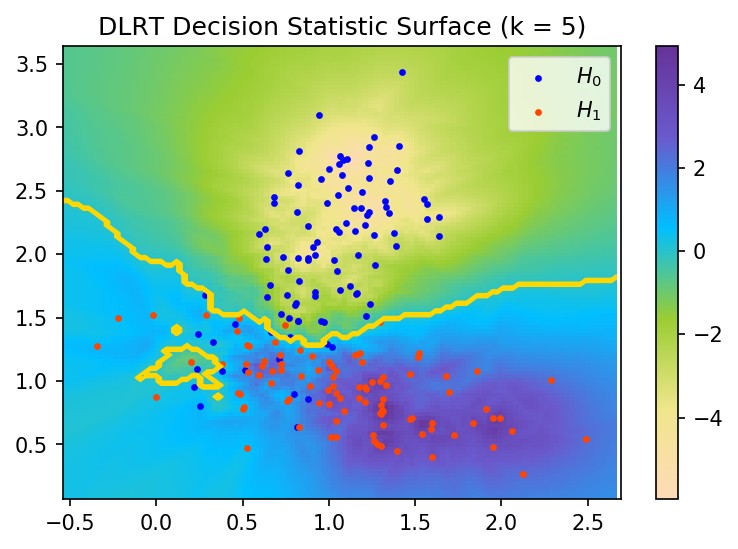

In [7]:
plotDLRTStatisticSurface(gaussian_df, 5, 0.03)